# SOFIA/FORCAST Galactic Center Source Detection Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#Load in the configuration file 
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW', 'FieldA9', 'FieldB9', 'FieldC9', 'FieldF9', 'FieldI9', 'FieldL9', 'FieldN9']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [2]:
#import configuration for selected file - Chage 'FieldN9' to the desired field name from the list above
from config import FieldN9 as field

#import additional values from the config file
from config import wavelength, segdetsig, finddetsig, bkgbox 
from config import dpath, dpathalt, ds9path

In [3]:
#import all required packages
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord,Angle 
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, Table, vstack

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, CircularAperture
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils import DAOStarFinder,IRAFStarFinder
#from photutils.utils import calc_total_error


from regions import read_ds9, write_ds9, CircleSkyRegion

## First Steps - Load data & perform background subtraction

In [4]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

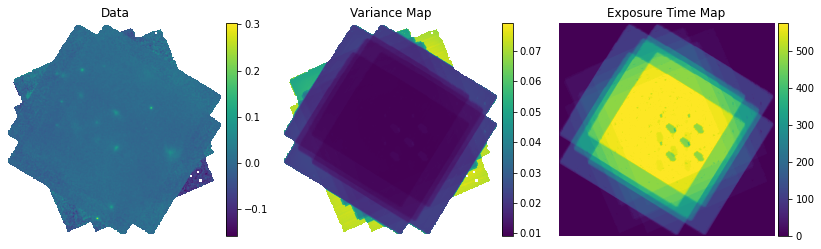

In [5]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))

ax1.set_title('Data')
im1=ax1.imshow(data,origin='lower')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_axis_off()

ax2.set_title('Variance Map')
im2=ax2.imshow(varmap,origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_axis_off()

ax3.set_title('Exposure Time Map')
im3=ax3.imshow(tmap,origin='lower')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_axis_off()
plt.show()

In [6]:
#create background model for image using median method
bkg_estimator = MedianBackground()  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(5, 5),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms #bkgbox
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = segdetsig*bkg_rms

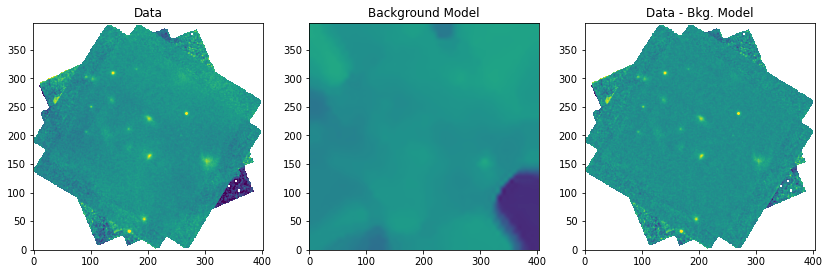

In [7]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

## Source Detection using Segmentation Map

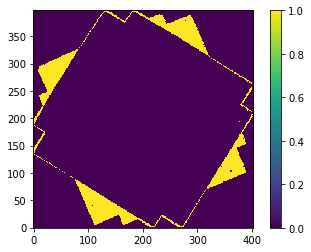

In [8]:
#create mask for 'bad' parts of the image (e.g., edges of field where dithers don't overlap well)
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
mask=np.where(tmapnorm<field.m1cut,tmapnorm,0).astype('bool') #create mask for any locations less than specified fraction of total integration time
#note this can be adjusted in the config file parameters

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [9]:
#Use a gaussian to smooth image prior to running the segmentation map - (FWHM 3x3, but can be adjusted in the line below)
sigma = 3.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

In [10]:
#Create Segmentation Map and detect sources
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, kernel=kernel)

In [11]:
#remove any that exist in masked region as defined in the config file
if field.m2lims is not None:
    mask2=np.zeros(np.shape(mask))
    for lim in field.m2lims:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))
if field.m3lims is not None:
    mask3=np.zeros(np.shape(mask))
    for lim in field.m3lims:
        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask3.astype('bool'))

In [12]:
#Perform deblending on sources found in segmentation map
if segm is not None:
    segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,kernel=kernel, nlevels=64,contrast=0.001)
else:
    segm_deblend=segm #if segm is empty pass it on to avoid errors

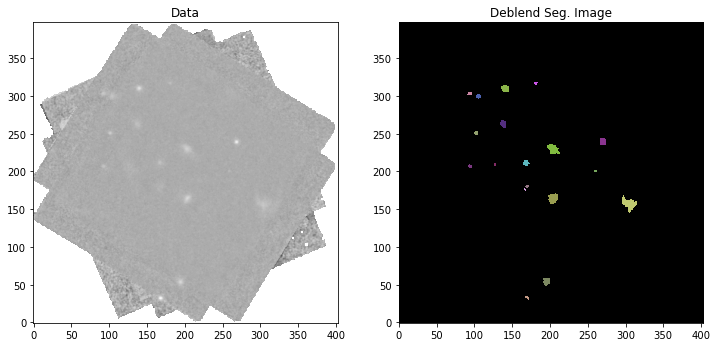

In [13]:
#make plot of segmentation image to show detected sources side by side with data
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
if segm is not None:
    cmap = segm.make_cmap(seed=123)
    ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Deblend Seg. Image')
plt.show()

In [14]:
#Build a table from the deblended segmentation map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background', 'area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#Specify table columns
SEGsources= catwerr.to_table(columns)

In [15]:
#calculate statistics for background cutouts in table - Think about removing this because it hasn't been very useful...
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(SEGsources['background'])):
    bkgdata=SEGsources['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to the table
SEGsources['segbkg_mean_sc']=segbkg_mean
SEGsources['segbkg_median_sc']=segbkg_median
SEGsources['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
SEGsources.remove_column('background')

In [16]:
#calculate noise stats - Think about removing this because it hasn't been very useful...


#sky noise from background
skynoise=np.sqrt(SEGsources['segbkg_std_sc']*SEGsources['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=SEGsources['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=SEGsources['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no source noise 

#calculate SNR for the segments
SEGsources['segmentSNR']=SEGsources['segment_flux']/ totalnoise 


    
#display table
SEGsources

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,168.67975195241294,33.234623255093524,"266.0532348592611,-29.44863644397799",-0.00848514994800359,0.0077482319762418915,0.15496463952483783,20.0,1.478437323011729,0.8054321802441861,-26.984757203863026,0.6806886112364967,0.8766284104006367,1.3183093516964643,0.8385750106814104,0.4552138479543807,1.835582634112664,2.803372424861074,6.059753699437328,2.362932386374696,2.7170029128104662,2.288427757351164,0.6799358370539682,0.007312428439721745,0.0073848836123481774,0.0009005217977152833,2.7392155640065217
2,194.30106616799742,54.16043915159811,"266.0469579552481,-29.444172453614065",-0.010998604987248707,0.005956107362573454,0.4764885890058763,80.0,2.342175165475484,2.05564307251877,-73.57914193278496,0.23230485487357938,0.029480311165314955,0.18663342845164235,0.4792762430758207,0.12233589407841972,1.139388056607331,5.189013867626984,5.183774525853816,2.3689069590740375,1.967257381252711,3.4246774130199737,1.0855053476029026,0.005773850684563828,0.005761426135944576,0.0011150433574315221,3.1597633351605836
3,303.8460437989197,156.7348877097112,"266.0201277343422,-29.422287369062765",0.002069422409835461,0.011072684286297917,2.4359905429855417,220.0,4.878011635617616,3.61768673909153,-32.66439137381176,0.052041000433862755,0.03124374912673622,0.06639250799900845,0.6708075907413247,0.2583685711865903,1.3483786705209797,10.11239006909291,12.82196626913386,4.25672400024545,2.190833216242508,6.161865306781185,1.5114379761699706,0.009326541106689127,0.009628680354011066,0.005812694180399482,3.6888597582647837
4,203.3787498249598,164.14880873754032,"266.04473448596156,-29.420708265023702",0.0016357584836721435,0.0074015720785058,1.0510232351478237,142.0,3.195175680546558,2.4604287350140592,52.010419550375445,0.13971453727790206,-0.06523346598066528,0.12342480415424159,0.6379896967336681,0.22995510074951964,1.2986255749156257,6.714924752771943,6.976653784478465,2.2746223066746807,1.8795826422209432,5.193643843626727,1.1539170773907172,0.007334237352207538,0.007633552490947012,0.0007914235977548225,4.6153431180905296
5,165.9303153476887,176.0086173137575,"266.05390612683294,-29.418177959678403",0.005682763919538556,0.003453675538736086,0.0241757287711526,7.0,0.9272113043114196,0.5132639502896216,-45.90832314148564,2.5212812065450056,2.6314408876825923,2.4378195641180254,0.8328115482167393,0.4464433857708521,1.8064999573576486,1.764670691632733,0.7765284617632735,1.0467225954973278,3.5295253500585804,0.11692803681008612,0.2564999977937222,0.0034509284219639397,0.003442373498195195,0.0002408637323428817,0.23011889319489445
6,169.41993467329448,180.29681927859133,"266.05305141254144,-29.41726318964818",0.006467700466764186,0.0037048348363217937,0.0592773573811487,16.0,1.2691262230297795,1.0181816134180817,42.98849347673268,0.7806718705151717,-0.342902704416105,0.8047883688419049,0.5969616428525965,0.19773022183137845,1.2464635054342275,2.7092586687162528,1.296095536329986,1.615998598878105,3.311765638948146,0.25207055668335143,0.3874287273986095,0.003683112868549361,0.0036725410552677163,0.0005203366130387189,0.40069082845553816
7,258.89046154695586,200.50219641696128,"266.03113976459787,-29.412952035756078",0.0005704473337614778,-0.0026261596961800865,-0.01575695817708052,6.0,0.7863753490577792,0.49862818156842664,3.4835073079074936,1.6259912540698611,-0.2917126593797266,4.013160943040763,0.7732640114503533,0.36591580322822426,1.57707762642746

In [17]:
#convert Qtable to Table so it can be written as fits
SEGsources=Table(SEGsources)

#write out the resulting table to file
SEGsources.write(field.name+'_'+str(wavelength)+'um_seg.fits',overwrite=True)

## Source Detection using DAO and IRAF routines

In [18]:
#First, create a mask for the data

#Make a cut based on exposure time. Note this is more agressive than SEG because we can't use 2D background with DAO or IRAF
maskTPS=np.where(tmapnorm<0.75,tmapnorm,0).astype('bool')

#create a single mask from the combination of mask parameters specified in the config file
if field.m3lims is not None:
    maskPS=(maskTPS == 1) | (mask2 == 1) | (mask3 == 1)
elif field.m2lims is not None:
    maskPS=(maskTPS == 1) | (mask2 == 1)
else:
    maskPS=(maskTPS == 1)

#create masked array for the background subtracted data
data_bkgsub_ma = np.ma.masked_array(data_bkgsub, mask=maskPS)

#plot the masked data - optional
#plt.figure()
#plt.imshow(data_bkgsub_ma,origin='lower')
#plt.colorbar()
#plt.show()

In [25]:
#get standard devaition of image to specify detection threshold
#std = np.median(bkg_rms) # use rms map value from background model - must be single value becuase methods don't allow for passing an array

#Alternatively - use sigma_clipped_stats on the image to estimate background for source finding
mean, median, std = sigma_clipped_stats(data_bkgsub, sigma=3.0)  

In [26]:
#now run starfinder routines to find sources 
daofind = DAOStarFinder(fwhm=3.2, threshold=finddetsig*std)
DAOsources = daofind(data_bkgsub_ma,mask=maskPS)

StarFinder = IRAFStarFinder(fwhm=3.2, threshold=finddetsig*std)
IRAFsources = StarFinder(data_bkgsub_ma,mask=maskPS)

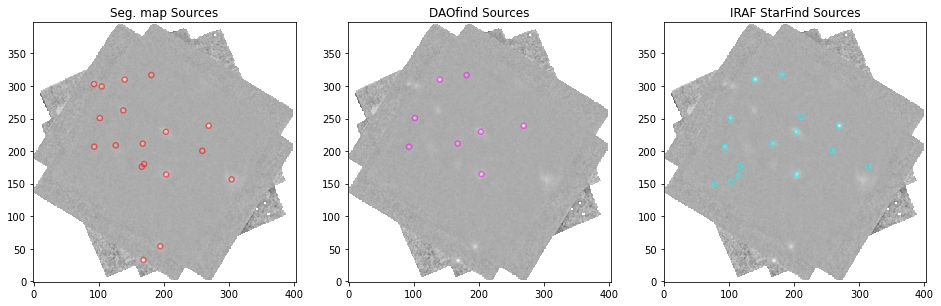

In [27]:
#plot data with apertures on detected sources
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)

if IRAFsources is not None:
    Ipositions = np.transpose((IRAFsources['xcentroid'], IRAFsources['ycentroid']))
    Iapertures = CircularAperture(Ipositions, r=4.)
    
if SEGsources is not None:
    Spositions = np.transpose((SEGsources['xcentroid'], SEGsources['ycentroid']))
    Sapertures = CircularAperture(Spositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
if SEGsources is not None:
    Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data_bkgsub, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data_bkgsub, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('IRAF StarFind Sources')
if IRAFsources is not None:
    Iapertures.plot(color='cyan', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

In [28]:
#Now add RA, DEC coordinates of sources to DAOsources table
if DAOsources is None:
    Nsources=0
else:
    Nsources=len(DAOsources['id'])

scs=[]

for i in range(0,Nsources):
    xcoord=DAOsources['xcentroid'][i]
    ycoord=DAOsources['ycentroid'][i]
    sc=pixel_to_skycoord(xcoord,ycoord,wcsmap)
    scs.append(sc)

if DAOsources is not None:
    DAOsources['sky_centroid']=scs

    #change format of columns to save fewer decimal places
    for col in DAOsources.colnames:
        if col!='sky_centroid': #skip sky centroid since its problematic in this context
            DAOsources[col].info.format = '%.4G'

#(optional) print DAO sources table
#DAOsources

In [29]:
#convert Qtable to Table so it can be written as fits
DAOsources=Table(DAOsources)

#write out the resulting table to file
DAOsources.write(field.name+'_'+str(wavelength)+'um_dao.fits',overwrite=True)

## Create ds9 region files to examine sources from above steps

In [30]:
# A few useful functions for creating ds9 files
def makeDS9reg(tab,radius,outname,color=None):
    #get source coordinates from table
    sourcecoords=tab['sky_centroid']

    #set size of regions 
    radius = Angle(radius, u.deg) 

    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(sourcecoords)):
        region = CircleSkyRegion(sourcecoords[i], radius)
        regions.append(region)
        
    #write out region file
    write_ds9(regions, outname)
    
    if color is not None:
        #change the color of the regions to red - no built in way to do this in regions package :-/
        with open(outname, 'r+') as f:
            text = f.read()
            text = re.sub(r'\)', r') # color='+str(color), text)
            f.seek(0)
            f.write(text)
            f.truncate()
    return text


def makeCombDS9file(text1,text2,outname):
    newregtext=text1+text2[45:]

    with open(outname, 'w+') as f:
        f.seek(0)
        f.write(newregtext)
        f.truncate()

In [31]:
#specify size of regions
radius = 0.00083333 #must be in degrees - current value is r=3"

#name to save file under and call to function creating the ds9 region file - Segmentation Map Sources
savenameSEG= field.name+'_segFind.reg'
t1=makeDS9reg(SEGsources,radius,savenameSEG,'red')

#name to save file under and call to function creating the ds9 region file - DAOfind Sources
savenameDAO= field.name+'_daoFind.reg'
t2=makeDS9reg(DAOsources,radius,savenameDAO,'cyan')

#save both sets of regions under the same file
savename=field.name+'.reg'
makeCombDS9file(t1,t2,savename)

In [32]:
#open ds9 and load in the region file to show sources - Note ds9 path must be correctly defined in config file for this to work
if ds9path is not None:
    subprocess.Popen(ds9path+' '+field.filename+ ' -mode region -regions load '+field.name+'.reg',shell=True) 

## Optional -  add user defined sources

User defined sources can be added to run with the photometry code. Simply create a new ds9 region file with the source positions added as regions. Name the file with the user defined sources field.name+'_ds9.reg' and specify the coordinates as Fk5 when saving. This will be loaded in the cells below and then passed to the photometry script if present. If the file does not exist, these steps will be skipped.

In [33]:
#read in user defined sources if they exist
UserFile=field.name+'_ds9.reg'
if os.path.isfile(field.name+'_ds9.reg'):
    sourcesDS9=read_ds9(field.name+'_ds9.reg')

    clist=[]
    
    for source in sourcesDS9:
        if source.visual['color']=='green':
            sc=source.center
            ra=sc.ra.value
            dec=sc.dec.value
            a=(ra,dec)
            clist.append(a)
            
    ds9sc=SkyCoord(clist,unit=u.deg,frame='fk5')
    usersources=True
    print('Number of user defined DS9 sources found: ', len(clist))  
else:
    usersources=False
    print('No user defined DS9 sources found')

Number of user defined DS9 sources found:  5


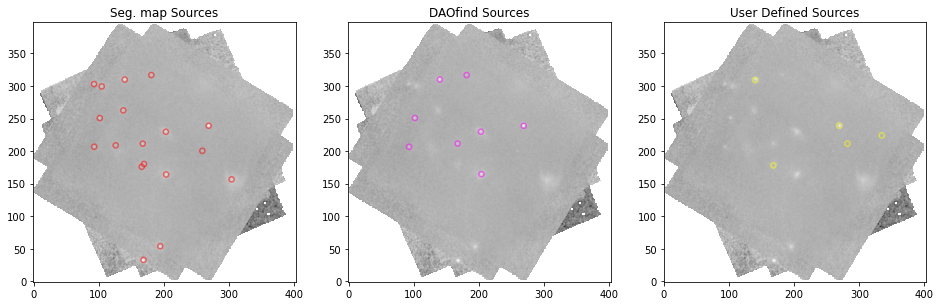

In [34]:
#plot data with sources found in each method used
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)
    
if SEGsources is not None:
    Spositions = np.transpose((SEGsources['xcentroid'], SEGsources['ycentroid']))
    Sapertures = CircularAperture(Spositions, r=4.)
    
if usersources:
    Upositions=np.transpose(skycoord_to_pixel(ds9sc,wcsmap))
    Uapertures = CircularAperture(Upositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
if SEGsources is not None:
    Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('User Defined Sources')
if usersources:
    Uapertures.plot(color='yellow', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

## Last, create a combined list of all sources found by each method

In [35]:
#find the 'not' indcies for sources in table
def findNOTindex(tab,index):
    allpos=np.linspace(0,len(tab)-1,len(tab),dtype=np.int64) 
    notindex=list(set(allpos)-set(index))
    return notindex

In [36]:
#get source coordinates from DAO and SEG
sourcesDao=DAOsources['sky_centroid']
sourcesSeg=SEGsources['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sourcesDao.search_around_sky(sourcesSeg, 3*u.arcsec)
print('Number of crossmatched DAO/SEG sources found: ', len(idx))

Number of crossmatched DAO/SEG sources found:  8


In [39]:
#create tables for sources - start with crossmatched sources
if len(rdx)>0:
    tab1=Table()
    tab1['sky_centroid']=sourcesDao[rdx]
    tab1['type']='C' #C - crossmatch
    t1=True
else:
    t1=False

#Find unique sources in list
notrdx=findNOTindex(sourcesDao,rdx)
if len(notrdx)>0:
    tab2=Table()
    tab2['sky_centroid']=sourcesDao[notrdx]
    tab2['type']='D' #D - DAO
    t2=True
else:
    t2=False

#Find unique sources in list
notidx=findNOTindex(sourcesSeg,idx)
if len(notidx)>0:
    tab3=Table()
    tab3['sky_centroid']=sourcesSeg[notidx]
    tab3['type']='S' #S - Segment
    t3=True
else:
    t3=False
    
    
    
if t1&t2&t3:
    #create combined list
    mergeTab=vstack([tab1,tab2,tab3])
elif t1 is False:
    mergeTab=vstack([tab2,tab3])
elif t2 is False:
    mergeTab=vstack([tab1,tab3])
elif t3 is False:
    mergeTab=vstack([tab1,tab2])
else:
    print('Throw error! position 1')



In [40]:
if usersources:
    #now check against user sources to ensure no duplication there. 
    mergeList1=mergeTab['sky_centroid']
    MLtype=mergeTab['type']

    idx,rdx, d2d, d3d = mergeList1.search_around_sky(ds9sc, 3*u.arcsec)
    print('Number of crossmatched sources found: ', len(idx))
    
    notrdx=findNOTindex(mergeList1,rdx)
    if len(notrdx)>0:
        tab4=Table()
        #elements only in DAO
        tab4['sky_centroid']=mergeList1[notrdx]
        tab4['type']=MLtype[notrdx] #adopt earlier type
        t4=True
    else:
        t4=False
    
    if len(rdx)>0:
        tab5=Table()
        tab5['sky_centroid']=mergeList1[rdx]
        tab5['type']='A' #A - ALL
        t5=True
    else:
        t5=False

    notidx=findNOTindex(ds9sc,idx)
    if len(notidx)>0:
        tab6=Table()
        tab6['sky_centroid']=ds9sc[notidx]
        tab6['type']='U' #U - user
        t6=True
    else:
        t6=False
        
    if t4&t5&t6:
        #create combined table
        CombTab=vstack([tab4,tab5,tab6])
    elif t6 is False:
        CombTab=vstack([tab4,tab5])
    elif t5 is False:
        CombTab=vstack([tab4,tab6])
    elif t4 is False:
        CombTab=vstack([tab5,tab6])
    else:
        print('Throw error! position 2')
    
else:
    CombTab=mergeTab
    print('No user Sources Defined')
    

Number of crossmatched sources found:  4


In [41]:
#write out the resulting table to file
CombTab.write(field.name+'_'+str(wavelength)+'um_CombinedSources.fits',overwrite=True)